### Refilter all. Aligning to genome makes no missing data. Adjust to remove loci private

In [1]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [2]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [3]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [4]:
analysis_dir = "/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering"

In [5]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering


In [6]:
vcf_file = os.path.join(analysis_dir, "CHDO.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/CHDO.vcf.gz'

## keep only biallelic first

In [8]:
!$vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'CHDO.biallelic'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/CHDO.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out CHDO.biallelic
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 274 out of 274 Individuals
Outputting VCF file...
After filtering, kept 684167 out of a possible 684176 Sites
Run Time = 387.00 seconds


In [11]:
vcf_biallelic = os.path.join(analysis_dir, "CHDO.biallelic.recode.vcf")
vcf_biallelic_gz = vcf_biallelic + '.gz'
!$bgzip -c $vcf_biallelic > {vcf_biallelic_gz}
!$tabix {vcf_biallelic_gz}

## Remove by MAF, missing, and thin next

In [12]:
!$vcftools \
--max-missing 0.6 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'CHDO_miss60_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/CHDO.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.6
	--out CHDO_miss60_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 274 out of 274 Individuals
Outputting VCF file...
After filtering, kept 31959 out of a possible 684167 Sites
Run Time = 53.00 seconds


In [13]:
!$vcftools \
--max-missing 0.7 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'CHDO_miss70_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/CHDO.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.7
	--out CHDO_miss70_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 274 out of 274 Individuals
Outputting VCF file...
After filtering, kept 31959 out of a possible 684167 Sites
Run Time = 52.00 seconds


In [16]:
vcf_filtered = "CHDO_miss70_thin100_MAF2.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [17]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Calulate missing data using vcfR

vcftools does not remove missing


In [18]:
%load_ext rpy2.ipython

In [20]:
%%R
require(readr)
library(data.table)
require(MASS)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/')

In [21]:
%%R
vcf <- read.vcfR("CHDO_miss70_thin100_MAF2.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [22]:
%%R
#get pl 
dp <- extract.gt(vcf, element = 'DP')

In [23]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 31959
 [1] "dDocent_Contig_13:7"   "dDocent_Contig_42:41"  "dDocent_Contig_51:16" 
 [4] "dDocent_Contig_53:81"  "dDocent_Contig_60:23"  "dDocent_Contig_67:8"  
 [7] "dDocent_Contig_68:67"  "dDocent_Contig_113:34" "dDocent_Contig_114:43"
[10] "dDocent_Contig_794:58"
                     CD2_IP_10 CD2_IP_11 CD2_IP_12 CD2_IP_1 CD2_IP_2
dDocent_Contig_13_7  "247"     "248"     "250"     "249"    "246"   
dDocent_Contig_42_41 "245"     "249"     "64"      "248"    "250"   
dDocent_Contig_51_16 "243"     "248"     "244"     "242"    "241"   
dDocent_Contig_53_81 "247"     "248"     "247"     "249"    "249"   
dDocent_Contig_60_23 "0"       "3"       "246"     "247"    "246"   


In [24]:
%%R
str(dp[1:5,1:5])

 chr [1:5, 1:5] "247" "245" "243" "247" "0" "248" "249" "248" "248" "3" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:5] "dDocent_Contig_13_7" "dDocent_Contig_42_41" "dDocent_Contig_51_16" "dDocent_Contig_53_81" ...
  ..$ : chr [1:5] "CD2_IP_10" "CD2_IP_11" "CD2_IP_12" "CD2_IP_1" ...


#### Calculate missing loci and individual

In [27]:
%%R
nloci <- ncol(dp)
nindv <- nrow(dp)
print(nloci)
print(nindv)

[1] 274
[1] 31959


In [28]:
%%R
miss_loci <- apply(dp,1, function(d) length(which(d == "0"))/nloci)
#miss_loci <- apply(dp[,1:100],1, function(d) (length(which(d == "0"))/100))
print(summary(miss_loci))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05839 0.19708 0.25840 0.41606 0.99635 


In [29]:
%%R
print(length(which(miss_loci <= .30)))
print(length(which(miss_loci <= .40)))
print(length(which(miss_loci <= .50)))
print(length(which(miss_loci <= .60)))
print(length(which(miss_loci <= .70)))

[1] 20180
[1] 23423
[1] 26310
[1] 28564
[1] 30388


In [30]:
%%R
keep_miss <- pos_ID[which(miss_loci <= .60)]
length(keep_miss)

[1] 28564


In [31]:
%%R
keep_miss60_df <- data.frame(chrom=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[1]),
                             pos=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[2]))
print(head(keep_miss60_df))    
write.table(keep_miss60_df,'keep_miss60.txt',quote=F,row.names=F,col.names=F,sep='\t')

                                 chrom pos
dDocent_Contig_13:7  dDocent_Contig_13   7
dDocent_Contig_42:41 dDocent_Contig_42  41
dDocent_Contig_51:16 dDocent_Contig_51  16
dDocent_Contig_53:81 dDocent_Contig_53  81
dDocent_Contig_60:23 dDocent_Contig_60  23
dDocent_Contig_67:8  dDocent_Contig_67   8


In [32]:
!head keep_miss60.txt

dDocent_Contig_13	7
dDocent_Contig_42	41
dDocent_Contig_51	16
dDocent_Contig_53	81
dDocent_Contig_60	23
dDocent_Contig_67	8
dDocent_Contig_68	67
dDocent_Contig_113	34
dDocent_Contig_114	43
dDocent_Contig_794	58


In [33]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "keep_miss60.txt")} \
--out {os.path.join(analysis_dir, "CHDO_miss60_thin100_MAF1")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf CHDO_miss70_thin100_MAF2.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/CHDO_miss60_thin100_MAF1
	--positions /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/keep_miss60.txt
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 274 out of 274 Individuals
Outputting VCF file...
After filtering, kept 28564 out of a possible 31959 Sites
Run Time = 17.00 seconds


In [34]:
vcf_filtered = "CHDO_miss60_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv

by do it by mean_depth cause no missing data 

In [35]:
!$vcftools --gzvcf {vcf_filtered_gz} \
--out {vcf_filtered_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf CHDO_miss60_thin100_MAF1.recode.vcf.gz
	--depth
	--out CHDO_miss60_thin100_MAF1.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 274 out of 274 Individuals
Outputting Mean Depth by Individual
After filtering, kept 28564 out of a possible 28564 Sites
Run Time = 2.00 seconds


In [36]:
depth_file = vcf_filtered_gz + ".idepth"
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,CD2_IP_10,28564,7.91160
1,CD2_IP_11,28564,9.42680
2,CD2_IP_12,28564,5.19577
3,CD2_IP_1,28564,8.12778
4,CD2_IP_2,28564,14.38840


In [37]:
depth_df.MEAN_DEPTH.describe()

count    274.000000
mean      13.506627
std        4.247861
min        4.662300
25%        9.999730
50%       13.966550
75%       16.732500
max       23.086300
Name: MEAN_DEPTH, dtype: float64

In [39]:
len(depth_df),len(depth_df[depth_df.MEAN_DEPTH <= 5]),len(depth_df[depth_df.MEAN_DEPTH <= 6]), len(depth_df[depth_df.MEAN_DEPTH <= 8])


(274, 2, 9, 35)

In [40]:
bad_indv = depth_df.INDV[depth_df.MEAN_DEPTH <= 5]

In [41]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv:
        o.write("%s\n" % elem)

In [42]:
!cat bad_indv.txt

INDV
CD2_LA_4
CD2_LA_5


In [43]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf CHDO_miss60_thin100_MAF1.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 272 out of 274 Individuals
Outputting VCF file...
After filtering, kept 28564 out of a possible 28564 Sites
Run Time = 16.00 seconds


In [44]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [45]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [46]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Outputting Mean Depth by Individual
After filtering, kept 28564 out of a possible 28564 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Outputting Depth for Each Site
After filtering, kept 28564 out of a possible 28564 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and 

After filtering, kept 272 out of 272 Individuals
Outputting HWE statistics (but only for biallelic loci)
After filtering, kept 28564 out of a possible 28564 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Outputting Individual Heterozygosity
After filtering, kept 28564 out of a possible 28564 Sites
Run Time = 2.00 seconds


In [47]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [48]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz'

In [49]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [50]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
dDocent_Contig_13-7,67213,16627797,247.10700,70.1842,544,0,0,0,999.0,2,...,19.368300,9.664597e-03,9.664597e-03,9.997265e-01,A,G,0.974265,0.025735,0.025735,0.268194
dDocent_Contig_42-41,65356,15972126,240.27900,990.4970,544,0,0,0,999.0,2,...,247.864300,3.208823e-19,3.208823e-19,1.000000e+00,C,T,0.957721,0.042279,0.042279,0.954686
dDocent_Contig_51-16,65069,15717005,239.22400,556.9050,544,0,0,0,999.0,2,...,2.786474,1.434578e-01,1.000000e+00,8.362602e-02,T,C,0.908088,0.091912,0.091912,-0.099190
dDocent_Contig_53-81,65456,16121284,240.64700,1363.4300,544,0,0,0,999.0,2,...,19.980090,2.492508e-07,1.000000e+00,1.430472e-07,T,C,0.786765,0.213235,0.213235,-0.268692
dDocent_Contig_60-23,25025,5437443,92.00370,11568.5000,544,0,0,0,999.0,2,...,1.713278,3.764539e-01,1.000000e+00,2.127437e-01,A,G,0.926471,0.073529,0.073529,-0.077381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dDocent_Contig_184313-15,1017,7357,3.73897,13.1161,544,0,0,0,999.0,2,...,2.803596,1.106027e-01,9.784852e-01,7.060737e-02,A,T,0.843750,0.156250,0.156250,-0.099500
dDocent_Contig_184319-37,722,7390,2.65441,20.1975,544,0,0,0,999.0,2,...,0.356252,1.000000e+00,1.000000e+00,7.221869e-01,A,G,0.965074,0.034926,0.034926,-0.034286
dDocent_Contig_184321-16,3063,47535,11.26100,48.1272,544,0,0,0,999.0,2,...,19.980090,2.492508e-07,1.000000e+00,1.430472e-07,G,T,0.786765,0.213235,0.213235,-0.268692
dDocent_Contig_184323-22,1140,8520,4.19118,13.8083,544,0,0,0,999.0,2,...,1.622241,3.763337e-01,1.000000e+00,2.305485e-01,G,A,0.928309,0.071691,0.071691,-0.075248


In [51]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
dDocent_Contig_13-7,dDocent_Contig_13,7,2,544,A:0.974265,G:0.0257353
dDocent_Contig_42-41,dDocent_Contig_42,41,2,544,C:0.957721,T:0.0422794
dDocent_Contig_51-16,dDocent_Contig_51,16,2,544,T:0.908088,C:0.0919118
dDocent_Contig_53-81,dDocent_Contig_53,81,2,544,T:0.786765,C:0.213235
dDocent_Contig_60-23,dDocent_Contig_60,23,2,544,A:0.926471,G:0.0735294
...,...,...,...,...,...,...
dDocent_Contig_184313-15,dDocent_Contig_184313,15,2,544,A:0.84375,T:0.15625
dDocent_Contig_184319-37,dDocent_Contig_184319,37,2,544,A:0.965074,G:0.0349265
dDocent_Contig_184321-16,dDocent_Contig_184321,16,2,544,G:0.786765,T:0.213235
dDocent_Contig_184323-22,dDocent_Contig_184323,22,2,544,G:0.928309,A:0.0716912


In [52]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
dDocent_Contig_13-7,dDocent_Contig_13,7,260/10/2,258.18/13.64/0.18,19.368300,9.664597e-03,9.664597e-03,9.997265e-01
dDocent_Contig_42-41,dDocent_Contig_42,41,260/1/11,249.49/22.03/0.49,247.864300,3.208823e-19,3.208823e-19,1.000000e+00
dDocent_Contig_51-16,dDocent_Contig_51,16,222/50/0,224.30/45.40/2.30,2.786474,1.434578e-01,1.000000e+00,8.362602e-02
dDocent_Contig_53-81,dDocent_Contig_53,81,156/116/0,168.37/91.26/12.37,19.980090,2.492508e-07,1.000000e+00,1.430472e-07
dDocent_Contig_60-23,dDocent_Contig_60,23,232/40/0,233.47/37.06/1.47,1.713278,3.764539e-01,1.000000e+00,2.127437e-01
...,...,...,...,...,...,...,...,...
dDocent_Contig_184313-15,dDocent_Contig_184313,15,190/79/3,193.64/71.72/6.64,2.803596,1.106027e-01,9.784852e-01,7.060737e-02
dDocent_Contig_184319-37,dDocent_Contig_184319,37,253/19/0,253.33/18.34/0.33,0.356252,1.000000e+00,1.000000e+00,7.221869e-01
dDocent_Contig_184321-16,dDocent_Contig_184321,16,156/116/0,168.37/91.26/12.37,19.980090,2.492508e-07,1.000000e+00,1.430472e-07
dDocent_Contig_184323-22,dDocent_Contig_184323,22,233/39/0,234.40/36.20/1.40,1.622241,3.763337e-01,1.000000e+00,2.305485e-01


In [53]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [54]:
loci_df.SUM_DEPTH.describe()

count    28564.000000
mean      3691.213065
std       6974.294091
min        168.000000
25%        923.000000
50%       1437.000000
75%       3092.250000
max      68242.000000
Name: SUM_DEPTH, dtype: float64

In [55]:
loci_df.MEAN_DEPTH.describe()

count    28564.000000
mean        13.570636
std         25.640786
min          0.617647
25%          3.393380
50%          5.283090
75%         11.368525
max        250.890000
Name: MEAN_DEPTH, dtype: float64

In [56]:
loci_df.QUAL.describe()

count    28564.000000
mean       977.769374
std        135.635202
min         12.812600
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: QUAL, dtype: float64

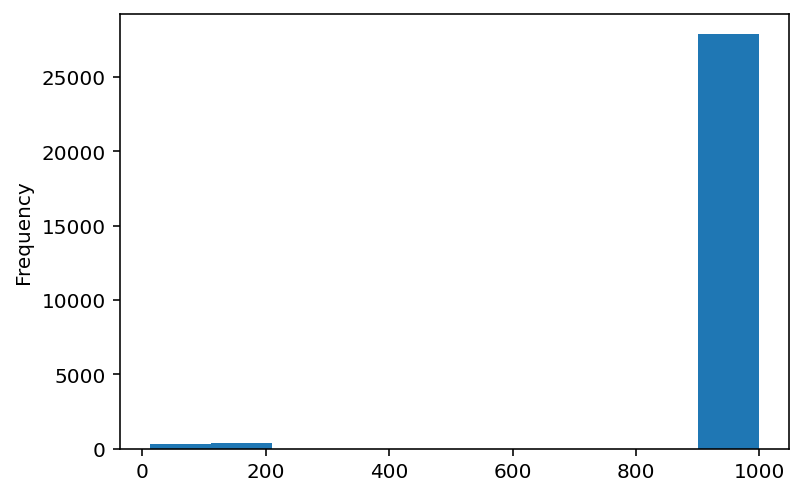

In [57]:
loci_df.QUAL.plot(kind="hist");

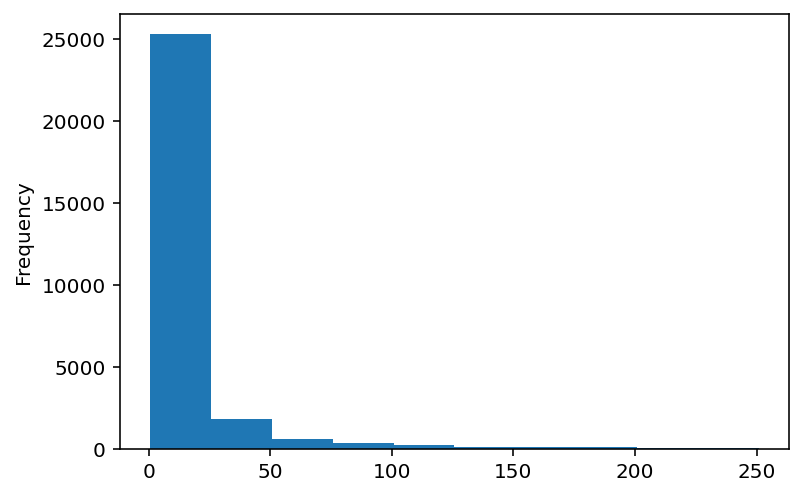

In [58]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [60]:
len(loci_df[loci_df.Fis == -9])

0

In [61]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=500])

(23950, 28125)

In [62]:
len(loci_df[loci_df.MEAN_DEPTH > 25 ]),len(loci_df[loci_df.MEAN_DEPTH >= 2])

(3398, 27808)

In [63]:
len(loci_df[loci_df.QUAL >= 20]) - len(loci_df[loci_df.QUAL >= 30])

5

In [69]:
len(loci_df[loci_df.QUAL >  200]), len(loci_df[loci_df.QUAL > 500]), len(loci_df[loci_df.QUAL == 999])

(27883, 27880, 27880)

In [70]:
 len(loci_df[loci_df.Fis >= -0.5]), len(loci_df[loci_df.MAF < 0.02])

(27943, 104)

In [71]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 2) & 
                  (df.MEAN_DEPTH < 25) & 
                  (df.QUAL >= 999) & 
                  (df.MAF >= 0.02) &
                  (df.Fis >= -0.5)]

In [72]:
#42513 with df.Fis >= -0.5
#42688 without 
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(23442, 25)

In [73]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [74]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Outputting VCF file...
After filtering, kept 23442 out of a possible 28564 Sites
Run Time = 14.00 seconds


In [75]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

## recalculate missing data (loci / indv) & remove alleles not present in one ssp_ploidy group

In [76]:
%%R
vcf <- read.vcfR("good_snps.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [77]:
%%R
#get DP 
dp <- extract.gt(vcf, element = 'DP')

In [78]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 23442
 [1] "dDocent_Contig_794:58"  "dDocent_Contig_860:5"   "dDocent_Contig_1448:8" 
 [4] "dDocent_Contig_2012:5"  "dDocent_Contig_2169:59" "dDocent_Contig_2541:34"
 [7] "dDocent_Contig_2679:47" "dDocent_Contig_2762:47" "dDocent_Contig_2933:69"
[10] "dDocent_Contig_3152:79"
                       CD2_IP_10 CD2_IP_11 CD2_IP_12 CD2_IP_1 CD2_IP_2
dDocent_Contig_794_58  "4"       "6"       "0"       "0"      "2"     
dDocent_Contig_860_5   "0"       "0"       "3"       "0"      "13"    
dDocent_Contig_1448_8  "18"      "25"      "0"       "0"      "5"     
dDocent_Contig_2012_5  "3"       "3"       "0"       "8"      "12"    
dDocent_Contig_2169_59 "7"       "0"       "0"       "2"      "2"     


In [82]:
%%R
ID <- colnames(dp)
ssp_ploid <- as.character(sapply(ID,function(s) unlist(strsplit(as.character(s),'_'))[1]))
ploidy <- sapply(ssp_ploid,function(s) gsub('(\\D)','',s,perl=TRUE))
print(length(ID))
print(ID[1:10])
print(ploidy[1:10])
print(unique(ploidy))

[1] 272
 [1] "CD2_IP_10" "CD2_IP_11" "CD2_IP_12" "CD2_IP_1"  "CD2_IP_2"  "CD2_IP_3" 
 [7] "CD2_IP_4"  "CD2_IP_5"  "CD2_IP_6"  "CD2_IP_7" 
CD2 CD2 CD2 CD2 CD2 CD2 CD2 CD2 CD2 CD2 
"2" "2" "2" "2" "2" "2" "2" "2" "2" "2" 
[1] "2" "4" "6"


#### Calculate missing loci and individual

In [99]:
%%R
print(dim(dp))
nindv <- ncol(dp)
nloci <- nrow(dp)
print(nloci)
print(nindv)

[1] 23442   272
[1] 23442
[1] 272


In [81]:
%%R
miss_loci <- apply(dp,1, function(d) length(which(d == "0"))/nindv)
#miss_loci <- apply(dp[,1:100],1, function(d) (length(which(d == "0"))/100))
print(length(miss_loci))
print(summary(miss_loci))

[1] 23442
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.08456 0.19118 0.22276 0.34559 0.60294 


In [102]:
%%R
#calculaate missing within each ploidy

#subset dp
dp2 <- dp[,which(ploidy=='2')]
dp4 <- dp[,which(ploidy=='4')]
dp6 <- dp[,which(ploidy=='6')]


#calc miss
miss_loci_2 <- apply(dp2,1, function(d) length(which(d == "0"))/ncol(dp2))
print(summary(miss_loci_2))
                       
miss_loci_4 <- apply(dp4,1, function(d) length(which(d == "0"))/ncol(dp4))
print(summary(miss_loci_4))

miss_loci_6 <- apply(dp6,1, function(d) length(which(d == "0"))/ncol(dp6))
print(summary(miss_loci_6))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.130   0.270   0.294   0.440   0.980 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05634 0.14789 0.18462 0.28873 0.80986 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.1000  0.1657  0.2667  1.0000 


In [104]:
%%R 
miss_index_2 <- which(miss_loci_2 >= 0.95)
miss_index_4 <- which(miss_loci_4 >= 0.95)
miss_index_6 <- which(miss_loci_6 >= 0.95)

miss_index <- c(miss_index_2,miss_index_4,miss_index_6)
print(miss_index)

keep_missP <- pos_ID[-miss_index]
print(length(pos_ID))
print(length(miss_index))
print(length(keep_missP))

 dDocent_Contig_42991_23  dDocent_Contig_57270_55  dDocent_Contig_73129_10 
                    2514                     4083                     5999 
 dDocent_Contig_98348_46 dDocent_Contig_106512_15 dDocent_Contig_122130_63 
                    9221                    10363                    12766 
dDocent_Contig_122933_24 dDocent_Contig_144329_35 dDocent_Contig_152783_38 
                   12877                    16374                    17732 
dDocent_Contig_158888_43 dDocent_Contig_180546_43  dDocent_Contig_45101_23 
                   18821                    22746                     2746 
 dDocent_Contig_65000_27  dDocent_Contig_74031_52   dDocent_Contig_96334_7 
                    5006                     6097                     8934 
dDocent_Contig_108570_42 dDocent_Contig_168919_14 
                   10653                    20606 
[1] 23442
[1] 17
[1] 23425


In [105]:
%%R
keep_missP_df <- data.frame(chrom=sapply(keep_missP,function(s) unlist(strsplit(as.character(s),':'))[1]),
                             pos=sapply(keep_missP,function(s) unlist(strsplit(as.character(s),':'))[2]))
print(head(keep_missP_df))    
write.table(keep_missP_df,'keep_missPloidy5.txt',quote=F,row.names=F,col.names=F,sep='\t')

                                     chrom pos
dDocent_Contig_794:58   dDocent_Contig_794  58
dDocent_Contig_860:5    dDocent_Contig_860   5
dDocent_Contig_1448:8  dDocent_Contig_1448   8
dDocent_Contig_2012:5  dDocent_Contig_2012   5
dDocent_Contig_2169:59 dDocent_Contig_2169  59
dDocent_Contig_2541:34 dDocent_Contig_2541  34


#### keep loci with less than 5% missing in each ploidy

### Miss indv!

In [106]:
%%R
nloci <- nrow(dp)
#print(nloci)

miss_indv <- apply(dp,2, function(d) length(which(d == "0"))/nloci)
print(length(miss_indv))
print(summary(miss_indv))

[1] 272
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02999 0.12560 0.21278 0.22276 0.29606 0.48260 


In [107]:
%%R
for (perc in seq(.1,.9,by=.1)){
    print(paste0('number of individuals with greater than ',perc*100,'% missing data.....  ',
                 length(which(miss_indv >= perc))))
}

[1] "number of individuals with greater than 10% missing data.....  245"
[1] "number of individuals with greater than 20% missing data.....  144"
[1] "number of individuals with greater than 30% missing data.....  65"
[1] "number of individuals with greater than 40% missing data.....  10"
[1] "number of individuals with greater than 50% missing data.....  0"
[1] "number of individuals with greater than 60% missing data.....  0"
[1] "number of individuals with greater than 70% missing data.....  0"
[1] "number of individuals with greater than 80% missing data.....  0"
[1] "number of individuals with greater than 90% missing data.....  0"


### No individuals have more than 50% missing data.  Only removing miss oci

In [115]:
!$vcftools --gzvcf $snps_gz \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "keep_missPloidy5.txt")} \
--out {os.path.join(analysis_dir, "final_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/good_snps.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/final_snps
	--positions /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/keep_missPloidy5.txt
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Outputting VCF file...
After filtering, kept 23425 out of a possible 23442 Sites
Run Time = 15.00 seconds


In [116]:
final_vcf = "final_snps.recode.vcf"
final_vcf_gz = "%s.gz" % final_vcf
!$bgzip -c $final_vcf > {final_vcf_gz}
!$tabix {final_vcf_gz}

# Make 012

In [117]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/final_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 23425 out of a possible 23425 Sites
Run Time = 3.00 seconds


# Get coverage per individual

In [118]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/final_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/CHDO/SNPcall/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 272 out of 272 Individuals
Outputting Mean Depth by Individual
After filtering, kept 23425 out of a possible 23425 Sites
Run Time = 2.00 seconds


In [119]:
depth_file = os.path.join(analysis_dir, "final_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,CD2_IP_10,23425,3.40154
1,CD2_IP_11,23425,4.32120
2,CD2_IP_12,23425,2.15266
3,CD2_IP_1,23425,3.83799
4,CD2_IP_2,23425,7.09541


In [120]:
depth_df.MEAN_DEPTH.describe()

count    272.000000
mean       6.597381
std        2.345765
min        2.152660
25%        4.650877
50%        6.661770
75%        8.303937
max       12.592300
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [121]:
!rm *vcf